# Entity Embeddings with MLJFlux

This demonstration is available as a Jupyter notebook or julia script
[here](https://github.com/FluxML/MLJFlux.jl/tree/dev/docs/src/common_workflows/entity_embeddings).

Entity embedding is newer deep learning approach for categorical encoding introduced in
2016 by Cheng Guo and Felix Berkhahn.  It employs a set of embedding layers to map each
categorical feature into a dense continuous vector in a similar fashion to how they are
employed in NLP architectures.

In MLJFlux, the `NeuralNetworkClassifier`, `NeuralNetworkRegressor`, and the
`MultitargetNeuralNetworkRegressor`` can be trained and evaluated with heterogenous data
(i.e., containing categorical features) because they have a built-in entity embedding
layer.  Moreover, they offer a `transform` method which encodes the categorical features
with the learned embeddings. Such embeddings can then be used as features in downstream
machine learning models.

In this notebook, we will explore how to use entity embeddings in MLJFlux models.

In [1]:
using Pkg
PKG_ENV = joinpath(@__DIR__, "..", "..", "..")
Pkg.activate(PKG_ENV);
Pkg.instantiate();

  Activating project at `~/GoogleDrive/Julia/MLJ/MLJFlux/docs`


**This script tested using Julia 1.10**

### Basic Imports

In [2]:
using MLJ
using Flux
using Optimisers
using CategoricalArrays
using DataFrames
using Random
using Tables
using ProgressMeter
using Plots
using ScientificTypes
using StableRNGs        # for reproducibility across Julia versions

stable_rng() = StableRNGs.StableRNG(246)

stable_rng (generic function with 1 method)

Generate some data

In [3]:
X, y = make_blobs(1000, 2; centers=2, as_table=true, rng=stable_rng())
X = DataFrame(X);

Visualize it

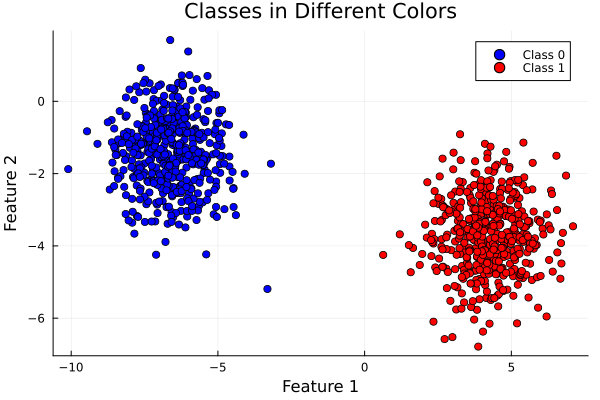

In [4]:
X_class0 = X[y .== 1, :]
X_class1 = X[y .== 2, :]

p = plot()

scatter!(p, X_class0[!, 1], X_class0[!, 2], markercolor=:blue, label="Class 0")
scatter!(p, X_class1[!, 1], X_class1[!, 2], markercolor=:red, label="Class 1")

title!(p, "Classes in Different Colors")
xlabel!("Feature 1")
ylabel!("Feature 2")

plot(p)

Let's write a function that creates categorical features C1 and C2 from x1 and x2 in a
meaningful way:

In [5]:
rng = stable_rng()
generate_C1(x1) = (x1 > mean(X.x1) ) ? rand(rng, ['A', 'B'])  : rand(rng, ['C', 'D'])
generate_C2(x2) = (x2 > mean(X.x2) ) ? rand(rng, ['X', 'Y'])  : rand(rng, ['Z'])

generate_C2 (generic function with 1 method)

Generate C1 and C2 columns

In [6]:
X[!, :C1] = [generate_C1(x) for x in X[!, :x1]];
X[!, :C2] = [generate_C2(x) for x in X[!, :x2]];
X[!, :R3] = rand(1000);  # A random continuous column.

Form final dataset using categorical and continuous columns

In [7]:
X = X[!, [:C1, :C2, :R3]];

It's also necessary to cast the categorical columns to the correct scientific type as
the embedding layer will have an effect on the model if and only if categorical columns
exist.

In [8]:
X = coerce(X, :C1=>Multiclass, :C2=>Multiclass);

Split the data

In [9]:
(X_train, X_test), (y_train, y_test) = partition(
        (X, y),
        0.8,
        multi = true,
        shuffle = true,
        stratify = y,
        rng = stable_rng(),
);

### Build MLJFlux Model

In [10]:
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg = MLJFlux


clf = MLJFlux.NeuralNetworkBinaryClassifier(
    builder = MLJFlux.Short(n_hidden = 5),
    optimiser = Optimisers.Adam(0.01),
    batch_size = 2,
    epochs = 100,
    acceleration = CPU1(), # use `CUDALibs()` on a GPU
    embedding_dims =  Dict(:C1 => 2, :C2 => 2,),
);

[ Info: For silent loading, specify `verbosity=0`. 
import MLJFlux ✔


Notice that we specified to embed each of the columns to 2D columns. By default, it uses
`min(numfeats - 1, 10)` for the new dimensionality of any categorical feature.

### Train and evaluate

In [11]:
mach = machine(clf, X_train, y_train)

fit!(mach, verbosity = 0)

trained Machine; caches model-specific representations of data
  model: NeuralNetworkBinaryClassifier(builder = Short(n_hidden = 5, …), …)
  args: 
    1:	Source @128 ⏎ ScientificTypesBase.Table{Union{AbstractVector{ScientificTypesBase.Continuous}, AbstractVector{ScientificTypesBase.Multiclass{4}}, AbstractVector{ScientificTypesBase.Multiclass{3}}}}
    2:	Source @759 ⏎ AbstractVector{ScientificTypesBase.Multiclass{2}}


Get predictions on the training data

In [12]:
y_pred = predict_mode(mach, X_test)
balanced_accuracy(y_pred, y_test)

1.0

Notice how the model has learnt to almost perfectly distinguish the classes and all the
information has been in the categorical variables.

### Visualize the embedding space

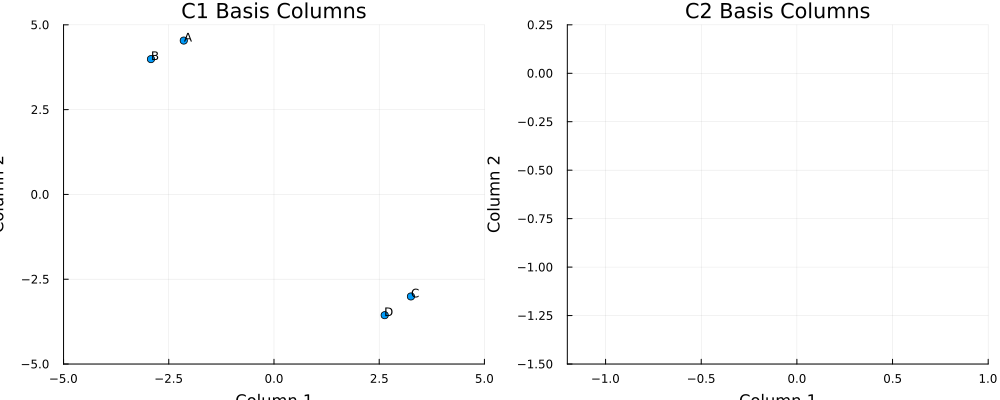

In [13]:
mapping_matrices = MLJFlux.get_embedding_matrices(
                fitted_params(mach).chain,
                [1, 2],             # feature indices
                [:C1, :C2],         # feature names (to assign to the indices)
            )

C1_basis = mapping_matrices[:C1]
C2_basis = mapping_matrices[:C2]

p1 = scatter(C1_basis[1, :], C1_basis[2, :],
             title = "C1 Basis Columns",
             xlabel = "Column 1",
             ylabel = "Column 2",
             xlim = (-5, 5),
             ylim = (-5, 5),
             label = nothing,
)

p2 = scatter(C2_basis[1, :], C2_basis[2, :],
             title = "C2 Basis Columns",
             xlabel = "Column 1",
             ylabel = "Column 2",
             xlim = (-1.2, 1.0),
             ylim = (-1.5, 0.25),
             label = nothing,
)

c1_cats = ['A', 'B', 'C', 'D']
for (i, col) in enumerate(eachcol(C1_basis))
    annotate!(p1, col[1] + 0.1, col[2] + 0.1, text(c1_cats[i], :black, 8))
end

c2_cats = ['X', 'Y', 'Z']
for (i, col) in enumerate(eachcol(C2_basis))
    annotate!(p2, col[1] + 0.1, col[2] + 0.1, text(string(c2_cats[i]), :black, 8))
end

plot(p1, p2, layout = (1, 2), size = (1000, 400))

As we can see, categories that were generated in a similar pattern were assigned similar
vectors. In a dataset, where some columns have high cardinality, it's expected that some
of the categories will exhibit similar patterns.

### Transform (embed) data

In [14]:
X_tr = MLJ.transform(mach, X);
first(X_tr, 5)

Row,C1_1,C1_2,C2_1,C2_2,R3
,Float32,Float32,Float32,Float32,Float64
1,3.25402,-3.0087,0.381745,1.33068,0.800321
2,2.63055,-3.56094,0.0284231,1.22988,0.82462
3,3.25402,-3.0087,0.381745,1.33068,0.791418
4,-2.14344,4.53556,-1.34338,2.30621,0.123086
5,-2.92311,3.98856,-1.34338,2.30621,0.715645


This will transform each categorical value into its corresponding embedding
vector. Continuous value will remain intact.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*